In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pickle
import string
import requests
import collections
import io
import tarfile
import urllib.request
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/yskn67/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
batch_size = 500
vocabulary_size = 7500
generations = 10000
model_learning_rate = 0.001

embedding_size = 200
doc_embedding_size = 100
concatenated_size = embedding_size + doc_embedding_size

num_sampled = int(batch_size / 2)
window_size = 3

save_embeddings_every = 5000
print_valid_every = 5000
print_loss_every = 100

stops = []

valid_words = ['love', 'hate', 'happy', 'sad', 'man', 'woman']

In [3]:
def load_movie_data():
    save_folder_name = '../data'
    pos_file = os.path.join(save_folder_name, 'rt-polaritydata', 'rt-polarity.pos')
    neg_file = os.path.join(save_folder_name, 'rt-polaritydata', 'rt-polarity.neg')
    if not os.path.exists(os.path.join(save_folder_name, 'rt-polaritydata')):
        movie_data_url = 'http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz'
        req = requests.get(movie_data_url, stream=True)
        with open(os.path.join(save_folder_name, 'temp_movie_review_temp.tar.gz'), 'wb') as f:
            for chunk in req.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
                    f.flush()
        tar = tarfile.open(os.path.join(save_folder_name, 'temp_movie_review_temp.tar.gz'), "r:gz")
        tar.extractall(path=save_folder_name)
        tar.close()
    
    pos_data = []
    with open(pos_file, 'r', encoding='latin-1') as f:
        for line in f:
            pos_data.append(line.encode('ascii', errors='ignore').decode())
    pos_data = [x.rstrip() for x in pos_data]
    
    neg_data = []
    with open(neg_file, 'r', encoding='latin-1') as f:
        for line in f:
            neg_data.append(line.encode('ascii', errors='ignore').decode())
    neg_data = [x.rstrip() for x in neg_data]
    
    texts = pos_data + neg_data
    target = [1] * len(pos_data) + [0] * len(neg_data)
    
    return (texts, target)

texts, target = load_movie_data()

In [4]:
def normalize_text(texts, stops):
    texts = [x.lower() for x in texts]
    texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]
    texts = [''.join(c for c in x if c not in '0123456789') for x in texts]
    texts = [' '.join([word for word in x.split() if word not in (stops)]) for x in texts]
    texts = [' '.join(x.split()) for x in texts]
    return texts
texts = normalize_text(texts, stops)
target = [target[ix] for ix, x in enumerate(texts) if len(x.split()) > window_size]
texts = [x for x in texts if len(x.split()) > window_size]

In [5]:
def build_dictionary(sentences, vocabulary_size):
    split_sentences = [s.split() for s in sentences]
    words = [x for sublist in split_sentences for x in sublist]
    count = [['RARE', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))
    word_dict = {}
    for word, word_count in count:
        word_dict[word] = len(word_dict)
    return word_dict

In [6]:
def text_to_numbers(sentences, word_dict):
    data = []
    for sentences in sentences:
        sentence_data = []
        for word in word_dict:
            if word in word_dict:
                word_ix = word_dict[word]
            else:
                word_ix = 0
            sentence_data.append(word_ix)
        data.append(sentence_data)
    return data

In [7]:
word_dictionary = build_dictionary(texts, vocabulary_size)
word_dictionary_rev = dict(zip(word_dictionary.values(), word_dictionary.keys()))
text_data = text_to_numbers(texts, word_dictionary)
valid_examples = [word_dictionary[x] for x in valid_words]

In [8]:
def generate_batch_data(sentences, batch_size, window_size, method='skip_gram'):
    batch_data = []
    label_data = []
    while len(batch_data) < batch_size:
        rand_sentence_ix = int(np.random.randint(len(sentences)))
        rand_sentences = sentences[rand_sentence_ix]
        window_sequences = [rand_sentences[max((ix - window_size), 0): (ix + window_size + 1)]
                               for ix, x in enumerate(rand_sentences)]
        label_indices = [ix if ix < window_size else window_size
                            for ix, x in enumerate(window_sequences)]
        
        if method == 'skip_gram':
            batch_and_labels = [(x[y], x[:y] + x[(y + 1):])
                                   for x, y in zip(window_sequences, label_indices)]
            tuple_data = [(x, y_) for x, y in batch_and_labels for y_ in y]
            batch, labels = [list(x) for x in zip(*tuple_data)]
        elif method == 'cbow':
            batch_and_labels = [(x[:y] + x[(y + 1):], x[y]) for x, y in zip(window_sequences, label_indices)]
            batch_and_labels = [(x, y) for x, y in batch_and_labels if len(x) == 2 * window_size]
            batch, labels = [list(x) for x in zip(*batch_and_labels)]
        elif method=='doc2vec':
            batch_and_labels = [(rand_sentences[i:i + window_size], rand_sentences[i + window_size]) for i in range(0, len(rand_sentences) - window_size)]
            batch, labels = [list(x) for x in zip(*batch_and_labels)]
            batch = [x + [rand_sentence_ix] for x in batch]
        else:
            raise ValueError('Method {} not implemented yet.'.format(method))
        batch_data.extend(batch[:batch_size])
        label_data.extend(labels[:batch_size])
        
    batch_data = batch_data[:batch_size]
    label_data = label_data[:batch_size]
    
    batch_data = np.array(batch_data)
    label_data = np.transpose(np.array([label_data]))
    
    return (batch_data, label_data)

In [9]:
with tf.Session() as sess:
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    doc_embeddings = tf.Variable(
        tf.random_uniform([len(texts), doc_embedding_size], -1.0, 1.0))
    x_inputs = tf.placeholder(tf.int32, shape=[None, window_size + 1])
    y_target = tf.placeholder(tf.int32, shape=[None, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    embed = tf.zeros([batch_size, embedding_size])
    for element in range(window_size):
        embed += tf.nn.embedding_lookup(embeddings, x_inputs[:, element])
    
    doc_indices = tf.slice(x_inputs, [0, window_size], [batch_size, 1])
    doc_embed = tf.nn.embedding_lookup(doc_embeddings, doc_indices)
    
    final_embed = tf.concat(axis=1, values=[embed, tf.squeeze(doc_embed)])
    
    nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, concatenated_size],
                                                 stddev=1.0 / np.sqrt(concatenated_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                         biases=nce_biases,
                                         labels=y_target,
                                         inputs=final_embed,
                                         num_sampled=num_sampled,
                                         num_classes=vocabulary_size))
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=model_learning_rate)
    train_step = optimizer.minimize(loss)
    
    saver = tf.train.Saver({"embeddings": embeddings, "doc_embeddings": doc_embeddings})
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    loss_vec = []
    loss_x_vec = []
    for i in range(generations):
        batch_input, batch_labels = generate_batch_data(text_data, batch_size,
                                                        window_size, method='doc2vec')
        feed_dict = {x_inputs: batch_input, y_target: batch_labels}
        sess.run(train_step, feed_dict=feed_dict)
        
        if (i + 1) % print_loss_every == 0:
            loss_val = sess.run(loss, feed_dict=feed_dict)
            loss_vec.append(loss_val)
            loss_x_vec.append(i + 1)
            print("Loss at step {} : {}".format(i + 1, loss_val))
            
        if (i + 1) % print_valid_every == 0:
            sim = sess.run(similarity)
            for j in range(len(valid_words)):
                valid_word = word_dictionary_rev[valid_examples[j]]
                top_k = 5
                nearest = (-sim[j, :]).argsort()[1: top_k + 1]
                log_str = "Nearest to {}:".format(valid_word)
                for k in range(top_k):
                    close_word = word_dictionary_rev[nearest[k]]
                    log_str = "{} {},".format(log_str, close_word)
                print(log_str)
                
        if (i + 1) % save_embeddings_every == 0:
            with open('movie_vocab.pkl', 'wb') as f:
                pickle.dump(word_dictionary, f)
            model_checkpoint_path = './doc2vec_movie_embeddings.ckpt'
            save_path = saver.save(sess, model_checkpoint_path)
            print('Model save in file: {}'.format(save_path))

Loss at step 100 : 647.7841796875
Loss at step 200 : 626.203125
Loss at step 300 : 646.7291259765625
Loss at step 400 : 590.0521850585938
Loss at step 500 : 599.6882934570312
Loss at step 600 : 631.5934448242188
Loss at step 700 : 602.53857421875
Loss at step 800 : 588.5360717773438
Loss at step 900 : 578.125244140625
Loss at step 1000 : 609.95556640625
Loss at step 1100 : 583.285888671875
Loss at step 1200 : 577.2083129882812
Loss at step 1300 : 594.3695678710938
Loss at step 1400 : 538.4241943359375
Loss at step 1500 : 582.6951293945312
Loss at step 1600 : 548.1031494140625
Loss at step 1700 : 571.9327392578125
Loss at step 1800 : 557.7359008789062
Loss at step 1900 : 516.8858642578125
Loss at step 2000 : 540.5281982421875
Loss at step 2100 : 596.3478393554688
Loss at step 2200 : 505.5379638671875
Loss at step 2300 : 540.4576416015625
Loss at step 2400 : 544.7398071289062
Loss at step 2500 : 550.2203979492188
Loss at step 2600 : 494.0953674316406
Loss at step 2700 : 505.5876159667969

In [10]:
max_words = 20
logistic_batch_size = 500

In [11]:
train_indices = np.random.choice(len(target), round(0.8 * len(target)), replace=False)
test_indices = np.array(list(set(range(len(target))) - set(train_indices)))
texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])

In [12]:
def text_to_numbers(sentences, word_dict):
    data = []
    for sentences in sentences:
        sentence_data = []
        for word in word_dict:
            if word in word_dict:
                word_ix = word_dict[word]
            else:
                word_ix = 0
            sentence_data.append(word_ix)
        data.append(sentence_data)
    return data
text_data_train = np.array(text_to_numbers(texts_train, word_dictionary))
text_data_test = np.array(text_to_numbers(texts_test, word_dictionary))

In [13]:
text_data_train = np.array([x[0:max_words] for x in [list(y) + [0] * max_words for y in text_data_train]])
text_data_test = np.array([x[0:max_words] for x in [list(y) + [0] * max_words for y in text_data_test]])

In [17]:
with tf.Session() as sess:
    log_x_inputs = tf.placeholder(shape=[None, max_words + 1], dtype=tf.int32)
    log_y_target = tf.placeholder(shape=[None, 1], dtype=tf.int32)
    
    log_embed = tf.zeros([logistic_batch_size, embedding_size])
    for element in range(max_words):
        log_embed += tf.nn.embedding_lookup(embeddings, log_x_inputs[:, element])
    
    log_doc_indices = tf.slice(log_x_inputs, [0, max_words], [logistic_batch_size, 1])
    log_doc_embed = tf.nn.embedding_lookup(doc_embeddings, log_doc_indices)
    log_final_embed = tf.concat(axis=1, values=[log_embed, tf.squeeze(log_doc_embed)])
    
    A = tf.Variable(tf.random_normal(shape=[concatenated_size, 1]))
    b = tf.Variable(tf.random_normal(shape=[1, 1]))
    model_output = tf.add(tf.matmul(log_final_embed, A), b)
    
    logistic_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=model_output,
        labels=tf.cast(log_y_target, tf.float32)
    ))
    
    prediction = tf.round(tf.sigmoid(model_output))
    predictions_correct = tf.cast(tf.equal(prediction,
                                           tf.cast(log_y_target, tf.float32)), tf.float32)
    accuracy = tf.reduce_mean(predictions_correct)
    
    logistic_opt = tf.train.AdagradOptimizer(0.01)
    logistic_train_step = logistic_opt.minimize(logistic_loss)
    init = tf.global_variables_initializer()
    sess.run(init)
    
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    i_data = []
    for i in range(10000):
        rand_index = np.random.choice(text_data_train.shape[0], size=logistic_batch_size)
        rand_x = text_data_train[rand_index]
        rand_x_doc_indices = train_indices[rand_index]
        rand_x = np.hstack((rand_x, np.transpose([rand_x_doc_indices])))
        rand_y = np.transpose([target_train[rand_index]])
        
        feed_dict = {log_x_inputs: rand_x, log_y_target: rand_y}
        sess.run(logistic_train_step, feed_dict=feed_dict)
        
        if (i + 1) % 100 == 0:
            rand_index_test = np.random.choice(text_data_test.shape[0], size=logistic_batch_size)
            rand_x_test = text_data_test[rand_index_test]
            rand_x_doc_indices_test = test_indices[rand_index_test]
            rand_x_test = np.hstack((rand_x_test, np.transpose([rand_x_doc_indices_test])))
            rand_y_test = np.transpose([target_test[rand_index_test]])
            test_feed_dict = {log_x_inputs: rand_x_test,
                              log_y_target: rand_y_test}
            i_data.append(i + 1)
            
            train_loss_temp = sess.run(logistic_loss, feed_dict=feed_dict)
            train_loss.append(train_loss_temp)
            
            test_loss_temp = sess.run(logistic_loss, feed_dict=test_feed_dict)
            test_loss.append(test_loss_temp)
            
            train_acc_temp = sess.run(accuracy, feed_dict=feed_dict)
            train_acc.append(train_acc_temp)
            
            test_acc_temp = sess.run(accuracy, feed_dict=test_feed_dict)
            test_acc.append(test_acc_temp)
            
        if (i + 1) % 500 == 0:
            acc_and_loss = [i + 1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
            acc_and_loss = [np.round(x, 2) for x in acc_and_loss]
            print('Generation # {}. Train Loss (Test Loss): {:.2f} ({:.2f}).\n                  Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

Generation # 500. Train Loss (Test Loss): 1.80 (1.82).
                  Train Acc (Test Acc): 0.50 (0.52)
Generation # 1000. Train Loss (Test Loss): 1.66 (1.60).
                  Train Acc (Test Acc): 0.49 (0.52)
Generation # 1500. Train Loss (Test Loss): 1.46 (1.61).
                  Train Acc (Test Acc): 0.55 (0.50)
Generation # 2000. Train Loss (Test Loss): 1.35 (1.45).
                  Train Acc (Test Acc): 0.53 (0.51)
Generation # 2500. Train Loss (Test Loss): 1.19 (1.34).
                  Train Acc (Test Acc): 0.53 (0.47)
Generation # 3000. Train Loss (Test Loss): 1.05 (1.36).
                  Train Acc (Test Acc): 0.55 (0.48)
Generation # 3500. Train Loss (Test Loss): 0.99 (1.09).
                  Train Acc (Test Acc): 0.55 (0.51)
Generation # 4000. Train Loss (Test Loss): 1.01 (1.13).
                  Train Acc (Test Acc): 0.55 (0.48)
Generation # 4500. Train Loss (Test Loss): 0.88 (1.03).
                  Train Acc (Test Acc): 0.57 (0.52)
Generation # 5000. Train Loss

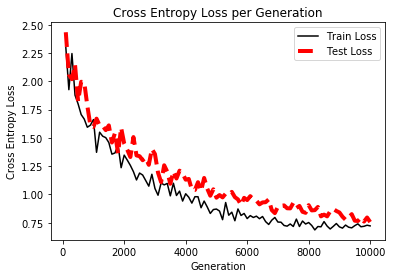

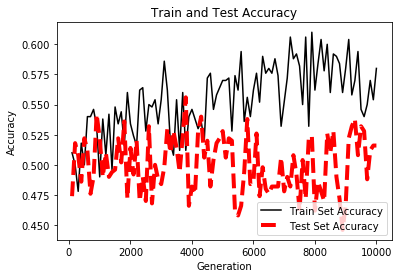

In [18]:
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()